In [34]:
import cv2
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from google.colab import drive
from torchvision import transforms
from torchvision.utils import draw_segmentation_masks
from sklearn.metrics import jaccard_score as jsc

drive.mount('/content/drive')
torch.cuda.empty_cache()
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Jaccard scores: 79%


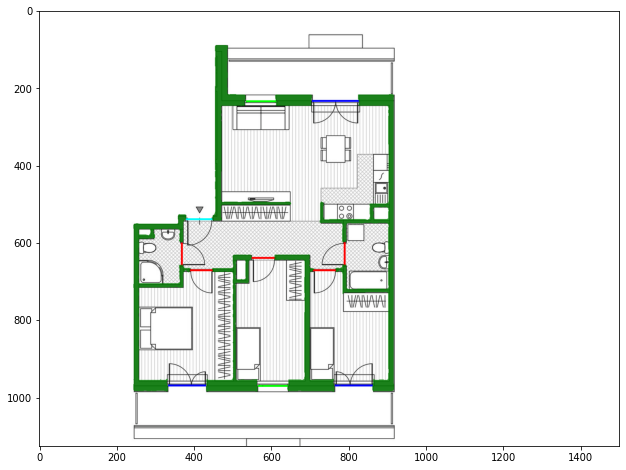

In [44]:
img_path = "/content/drive/MyDrive/floor-plans/segmentation/Dataset/images/test/E16/o.png"
origin = cv2.imread(img_path)
x = cv2.cvtColor(origin, cv2.COLOR_BGR2RGB)
tr = transforms.Compose([ 
  transforms.ToTensor(),
  transforms.Normalize((0.7128, 0.7113, 0.7055), (0.3947, 0.3904, 0.3886)),
])
x = tr(x)
x = torch.unsqueeze(x.to(device).float(),0)
model = torchvision.models.segmentation.deeplabv3_resnet50(num_classes=1).to(device)
model_path = "/content/drive/MyDrive/floor-plans/3d/models/mask_model"
model.load_state_dict(torch.load(model_path), strict=False)
with torch.no_grad():
  model.eval()
  pred = model(x)['out']
  classifier = torch.nn.Sigmoid()
  pred = classifier(pred) 
  invTrans = transforms.Compose([
    transforms.Normalize((0., 0., 0.),(1/0.3947, 1/0.3904, 1/0.3886)),
    transforms.Normalize((-0.7128, -0.7113, -0.7055),(1., 1., 1.)),
  ])
  ox = invTrans(x)
  ox = (ox*255).type(torch.uint8).cpu()
  mask = torch.ge(pred, 0.1446375846862793).cpu()
  out = draw_segmentation_masks(ox[0], mask[0,0], colors=["green"])
  out = torch.permute(out, (1,2,0))
  ground_truth_path = "/content/drive/MyDrive/floor-plans/segmentation/Dataset/images/test/E16/w.png"  
  ground_truth_img = cv2.imread(ground_truth_path)
  ground_truth_img = cv2.cvtColor(ground_truth_img, cv2.COLOR_BGR2GRAY)
  target = ground_truth_img == 255  
  labels = mask.numpy().reshape(-1)
  target = target.reshape(-1)
  print(f"Jaccard scores: {int(round(jsc(target, labels), 2)*100)}%")
  plt.rcParams["figure.figsize"] = (12,8)
  plt.imshow(out)
  plt.show()